In [22]:
import torch
import numpy as np 
import torchvision
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from tqdm import trange

from datautils import load_mnist

def load_data(name, pos_class, neg_class):
	subset_labels = (pos_class, neg_class)
	train_loader, test_loader = load_mnist(batch_size=32, flatten=True, subset_labels=subset_labels)	
	return train_loader.dataset.tensors, test_loader.dataset.tensors

def create_model(**kwargs):
	# C = 1.0 / (self.num_train_examples * self.weight_decay)
	return LogisticRegression(
		# C=C,
        # penalty="l2",
		tol=1e-8,
		fit_intercept=False,
		solver="lbfgs",
		warm_start=True,
		max_iter=1000,
		**kwargs,
	)
	
def train_model(model, x_train, y_train, x_test, y_test):
	model.fit(x_train, y_train)

	y_pred = model.predict(x_train)
	train_acc = accuracy_score(y_train, y_pred) 

	y_pred = model.predict(x_test)
	test_acc = accuracy_score(y_test, y_pred)
	print(f"train acc: {train_acc:.4f}, test acc: {test_acc:.4f}")

def sigmoid(x): return 1 / (1 + torch.exp(-x))

train acc: 0.8894, test acc: 0.9816
hessian min eigval 0.009999999776482582
hessian max eigval 3.6559624671936035


100%|████████████████████████████████████████████████████████████████| 12107/12107 [00:00<00:00, 17188.50it/s]


0.79


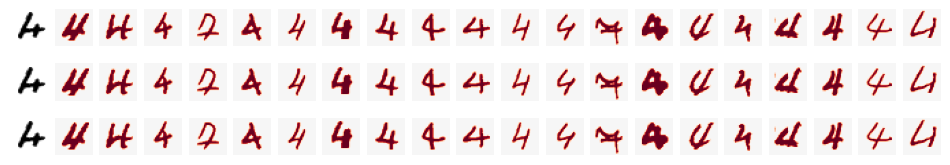

In [44]:
# pos_class, neg_class = 0, 1
# pos_class, neg_class = 1, 7
pos_class, neg_class = 4, 7 ## works well

(x_train, y_train), (x_test, y_test) = load_data("MNIST", pos_class, neg_class)

# transform labels
y_train = torch.where(y_train==pos_class, 0., 1.)

flip_idxs = np.random.choice(range(len(y_train)), size=int(len(y_train)*0.1), replace=False)
y_train[flip_idxs] = y_train[flip_idxs] * -1 + 1

y_test = torch.where(y_test==pos_class, 0., 1.)

model = create_model()
train_model(model, x_train, y_train, x_test, y_test) 
W = torch.tensor(model.coef_.T, dtype=torch.float)
z = x_train @ W
h = sigmoid(z)

d_ii = (h*(1-h)).squeeze()
D = torch.diag(d_ii)

y_target = y_test
y_pred = torch.tensor(model.predict_proba(x_test)[:,1]).to(torch.float)
test_loss = torch.nn.functional.binary_cross_entropy(y_pred, y_target, reduction="none")

_test_loss_pos_class = np.where(y_test==0, test_loss, np.nan)
test_idx = np.nanargmin(_test_loss_pos_class)
# test_idx = np.nanargmax(_test_loss_pos_class)
# test_idx = 1700
# test_idx = 1413

damp = 1e-2

hess = (x_train.T @ D @ x_train) / len(x_train) + damp * torch.eye(len(W))
inv_hess = torch.inverse(hess)
eigvals = np.linalg.eigvalsh(hess.cpu().numpy())
print(f"hessian min eigval {np.min(eigvals).item()}")
print(f"hessian max eigval {np.max(eigvals).item()}")


xt = x_test[test_idx].reshape(1,-1)
yt = y_test[test_idx] * 2 - 1

influences = []
for i in trange(len(x_train)):
    xtt = x_train[i].reshape(1,-1)
    ytt = y_train[i] * 2 - 1

    score = (yt * ytt * sigmoid(-yt * xt @ W) * sigmoid(-ytt * xtt @ W) * xt @ inv_hess @ xtt.T) / len(x_train)
    influences.append(score) ## order = indices

influences = torch.tensor(influences)
# values, indices = torch.sort(influences.abs())
values, indices = torch.sort(influences)


# plot influential samples

split_k = 20
_, axes = plt.subplots(ncols=split_k+1, nrows=3, figsize=(12,2))

axes[0][0].imshow(x_test[test_idx].reshape(28,28), cmap="gray_r")
axes[0][0].axis("off")

axes[1][0].imshow(x_test[test_idx].reshape(28,28), cmap="gray_r")
axes[1][0].axis("off")

axes[2][0].imshow(x_test[test_idx].reshape(28,28), cmap="gray_r")
axes[2][0].axis("off")

# influential_samples = np.array_split(indices, split_k)
influential_samples = np.array_split(indices, len(x_train))

count = 0
for _is in influential_samples[:100]:
    if _is.item() in flip_idxs:
        count += 1

print(count / 100.)




# influential_samples = influential_samples[:10] + influential_samples[-10:][::-1]
influential_samples = influential_samples[:20]
for i, samples in enumerate(influential_samples, start=1): 
    sgns = torch.where(y_train[samples] == y_test[test_idx], 1, -1).reshape(-1,1,1)  
    avg_sample = torch.mean(x_train[samples].reshape(-1,28,28) * sgns, axis=0)
    max_sample = torch.max(x_train[samples].reshape(-1,28,28) * sgns, axis=0).values
    min_sample = torch.min(x_train[samples].reshape(-1,28,28) * sgns, axis=0).values
    
    norm = mcolors.TwoSlopeNorm(vcenter=0)
    axes[0][i].imshow(avg_sample, cmap="RdBu", norm=norm)
    axes[0][i].axis("off")

    axes[1][i].imshow(max_sample, cmap="RdBu", norm=norm)
    axes[1][i].axis("off")

    axes[2][i].imshow(min_sample, cmap="RdBu", norm=norm)
    axes[2][i].axis("off")

In [203]:
qts = torch.quantile(values, q=torch.linspace(0, 1, 101))

In [211]:
qts[-2:]

tensor([2.6115e-12, 1.6469e-11])

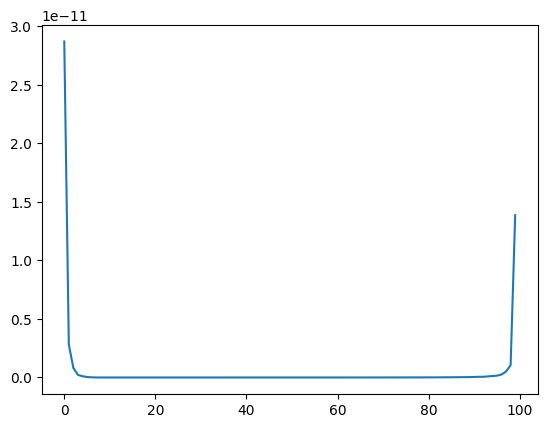

In [216]:
plt.plot(qts.diff(1))

In [119]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(x_train)
kmeans.labels_, kmeans.cluster_centers_

(array([1, 1, 1, ..., 1, 0, 1], dtype=int32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [101]:
kmeans.predict(x_test[test_idx].reshape(1,-1))

array([1], dtype=int32)

np.float64(64.38578189130799)

In [113]:
dists = []
for i in range(len(x_test)):
    dist = ((kmeans.cluster_centers_[0] - x_test[i].numpy()) ** 2).sum()
    dists.append(dist)

In [114]:
max(dists)

np.float64(90.13763271989555)

In [115]:
torch.sort(torch.tensor(dists))

torch.return_types.sort(
values=tensor([16.6645, 17.2079, 17.7722,  ..., 86.4661, 87.6277, 90.1376],
       dtype=torch.float64),
indices=tensor([1413,  875,  427,  ..., 1271,  635, 1700]))

<Figure size 1000x800 with 0 Axes>

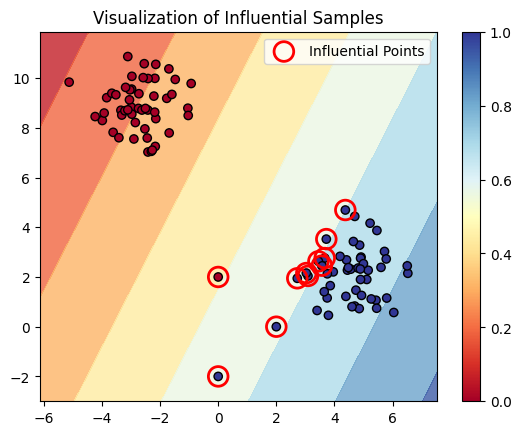

Details of influential points:
Point 7: Coordinates = [3.08921541 2.04173266], Class = 1, Influence Score = 0.0218
Point 17: Coordinates = [3.56898634 2.4556421 ], Class = 1, Influence Score = 0.0147
Point 29: Coordinates = [4.375222   4.69333885], Class = 1, Influence Score = 0.0184
Point 42: Coordinates = [3.66519717 2.76025429], Class = 1, Influence Score = 0.0155
Point 49: Coordinates = [3.44857534 2.62972329], Class = 1, Influence Score = 0.0191
Point 63: Coordinates = [2.72110762 1.94665581], Class = 1, Influence Score = 0.0333
Point 68: Coordinates = [3.0323956  2.15780354], Class = 1, Influence Score = 0.0251
Point 78: Coordinates = [3.7204546  3.52310409], Class = 1, Influence Score = 0.0223
Point 100: Coordinates = [0. 2.], Class = 0, Influence Score = 0.4260
Point 101: Coordinates = [ 0. -2.], Class = 1, Influence Score = 0.1157
Point 102: Coordinates = [2. 0.], Class = 1, Influence Score = 0.0282


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay

# Generate synthetic data
X, y = make_blobs(n_samples=100, centers=2, random_state=42)

# Add a few potentially influential points
X = np.vstack([X, [[0, 2], [0, -2], [2, 0]]])
y = np.hstack([y, [0, 1, 1]])

# Fit a logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Function to compute influence (simplified for visualization)
def compute_influence(model, X, y):
    probs = model.predict_proba(X)[:, 1]
    return np.abs(probs - y)

# Compute influence scores
influence_scores = compute_influence(model, X, y)

# Visualize the data and decision boundary
plt.figure(figsize=(10, 8))
DecisionBoundaryDisplay.from_estimator(
    model, X, cmap=plt.cm.RdYlBu, alpha=0.8
)
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black')
plt.colorbar(scatter)

# Highlight influential points
influential_threshold = np.percentile(influence_scores, 90)
influential_points = influence_scores >= influential_threshold
plt.scatter(X[influential_points, 0], X[influential_points, 1], 
            s=200, facecolors='none', edgecolors='r', linewidth=2,
            label='Influential Points')

plt.title('Visualization of Influential Samples')
plt.legend()
plt.show()

# Print details of influential points
influential_indices = np.where(influential_points)[0]
print("Details of influential points:")
for idx in influential_indices:
    print(f"Point {idx}: Coordinates = {X[idx]}, Class = {y[idx]}, Influence Score = {influence_scores[idx]:.4f}")